In [1]:
import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.tests.test_einsum import sizes

from Python import config
from Python.config import FILE_REACTOME_GENES, PATH_REACTOME, FILE_REACTOME_PROTEOFORMS, \
    FILE_REACTOME_PROTEIN_INTERACTIONS, FILE_PROTEOFORMS_SEARCH, PATH_RESOURCES, FILE_PATHWAYMATCHER, \
    URL_PATHWAYMATCHER, FILE_REACTOME_PROTEOFORM_INTERACTIONS, FILE_REACTOME_GENE_INTERACTIONS, FILE_REACTOME_PROTEINS, \
    LEVELS
from Python.lib.data_read_write import create_pathwaymatcher_files
from Python.lib.download import download_if_not_exists

config.set_root_wd()

Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


In [2]:
# What is fixed for all sources? These files are generated following the Replication.md instructions in the Wiki.
## genes, proteins and proteoforms universe list (full network nodes)
## genes, proteins and proteoforms interactions (full network links)
## Mapping from genes to proteins, and from proteins to proteoforms

create_pathwaymatcher_files(PATH_REACTOME, FILE_REACTOME_GENES, FILE_REACTOME_PROTEINS,
                            FILE_REACTOME_PROTEOFORMS, FILE_REACTOME_GENE_INTERACTIONS,
                            FILE_REACTOME_PROTEIN_INTERACTIONS, FILE_REACTOME_PROTEOFORM_INTERACTIONS,
                            FILE_PROTEOFORMS_SEARCH,
                            PATH_RESOURCES, FILE_PATHWAYMATCHER, URL_PATHWAYMATCHER)

PathwayMatcher files READY


In [16]:
def avg_degree(filename):
    entities = {}
    with open(filename) as fg:
        interaction = fg.readline()
        interaction = fg.readline()
        while interaction:
            # print(interaction)
            fields = interaction.split('\t')
            entities.setdefault(fields[0].strip(), set()).add(fields[1].strip())
            entities.setdefault(fields[1].strip(), set()).add(fields[0].strip())
            interaction = fg.readline()
    print("Number of entities: ", len(entities))
    
    genes_degrees = [len(entry[1]) for entry in entities.items()]
    avg_degree = sum(genes_degrees)/len(genes_degrees)
    print("Average number of interacting entities: {:.2f}".format(avg_degree) )    
    return avg_degree

# Calculate number of neighbours of each node
avg_degree_genes = avg_degree(PATH_REACTOME + FILE_REACTOME_GENE_INTERACTIONS)
avg_degree_proteins = avg_degree(PATH_REACTOME + FILE_REACTOME_PROTEIN_INTERACTIONS)
avg_degree_proteoforms = avg_degree(PATH_REACTOME + FILE_REACTOME_PROTEOFORM_INTERACTIONS)

Number of entities:  21992
Average number of interacting genes: 186.81
Number of entities:  9841
Average number of interacting genes: 92.03
Number of entities:  13002
Average number of interacting genes: 104.51


In [9]:
# What is needed from each source? 
## Gene/Protein Modules file (network regions)

# PheGenI Phenotypes
download_if_not_exists("resources/PheGenI/", 
                       "PheGenI_Association.txt", 
                       "https://www.ncbi.nlm.nih.gov/projects/gap/eqtl/EpiViewBE.cgi?type=dl.tab",
                       "PheGenI modules")

# Jensen Lab Diseases
download_if_not_exists("resources/Jensen/",
                       "human_disease_textmining_filtered.tsv",
                       "http://download.jensenlab.org/human_disease_textmining_filtered.tsv",
                       "Jensen Lab Diseases")

# from lib.conversions import create_gene_to_protein_mapping
# 
# path_file_genes = "../resources/Reactome/v70/Genes/all_genes_v70.csv"
# create_gene_to_protein_mapping(path_file_genes, "../resources/UniProt/", "mapping_proteins_to_genes_v70.tab", 1000)
dataset="PheGenI" 
# dataset="Pathways" 
# dataset="Jensen" 
print("Module files READY")

In [10]:
# Generates module files: gene_modules.tsv, protein_modules.tsv and proteoform_modules.tsv
# Generates single module files at each level: gene, protein and proteoform file for each trait
# Module sizes for genes, protein and proteoform levels
# Variation in module sizes when going from one level to the other
# Three files (for genes, proteins and proteoforms) with the Overlap similarity of each 
# pair of traits.
# Creates a file with a selection of trait pair examples which show decrease in the overlap. 

In [19]:
sizes_dict_connected = {level: pd.read_csv(f"reports/modules/module_sizes_{level}.tsv", sep="\t") for level in LEVELS}
sizes_dict_disconnected = {level: pd.read_csv(f"reports/modules_keep_disconnected/module_sizes_{level}.tsv", sep="\t") for level in LEVELS}
for level in LEVELS:
    print(f"\n{level}")
    print(sizes_dict_connected[level].describe())
    print(sizes_dict_disconnected[level].describe())
    sizes_dict_connected[level]["CONNECTEDNESS"] = "connected"
    sizes_dict_disconnected[level]["CONNECTEDNESS"] = "disconnected"

sizes_df_connected = pd.concat(sizes_dict_connected, names=["level", "index"])
sizes_df_disconnected = pd.concat(sizes_dict_disconnected, names=["level", "index"])
# sizes_df[sizes_df.index.get_level_values("level") == "genes"]
# sizes_df = pd.concat([sizes_df_connected, sizes_dict_disconnected], names=["level", "index"])
# sizes_df
sizes_df_connected["LEVEL"] = sizes_df_connected.index.get_level_values("level")
sizes_df_disconnected["LEVEL"] = sizes_df_disconnected.index.get_level_values("level")
sizes_df = pd.concat([sizes_df_connected, sizes_df_disconnected])
sizes_df


genes
             SIZE
count  792.000000
mean     3.445707
std     11.633449
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    141.000000
             SIZE
count  792.000000
mean    11.867424
std     25.251481
min      1.000000
25%      2.000000
50%      4.000000
75%     10.000000
max    257.000000

proteins
             SIZE
count  792.000000
mean     4.707071
std     14.607725
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    140.000000
             SIZE
count  792.000000
mean    14.083333
std     29.044247
min      1.000000
25%      2.000000
50%      4.000000
75%     13.000000
max    271.000000

proteoforms
             SIZE
count  792.000000
mean     7.037879
std     23.795081
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    283.000000
             SIZE
count  792.000000
mean    18.588384
std     40.643680
min      0.000000
25%      2.000000
50%      5.000000
75%     16.000000
max    417.00000

MODULE  SIZE  \
level       index                                                            
genes       0                                ADAMTS13 protein, human     0   
            1      Amyloidosis, Cerebral, with Spongiform Encepha...     0   
            2                                    Anemia, Sickle Cell    11   
            3                                Antibodies, Antinuclear     0   
            4                           Antibodies, Antiphospholipid     0   
...                                                              ...   ...   
proteoforms 787                                         temozolomide     2   
            788                         thiopurine methyltransferase     3   
            789                        thyroid microsomal antibodies     3   
            790                                von Willebrand Factor     6   
            791                                          ziprasidone     1   

                  CONNECTEDNESS        LEVEL  
level       index                             
genes       0         connected        genes  
            1         connected        genes  
            2         connected        genes  
            3         connected        genes  
            4         connected        genes  
...                         ...          ...  
proteoforms 787    disconnected  proteoforms  
            788    disconnected  proteoforms  
            789    disconnected  proteoforms  
            790    disconnected  proteoforms  
            791    disconnected  proteoforms  

[4752 rows x 4 columns]

c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


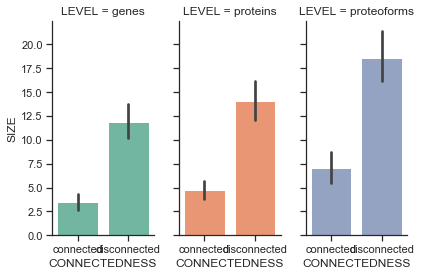

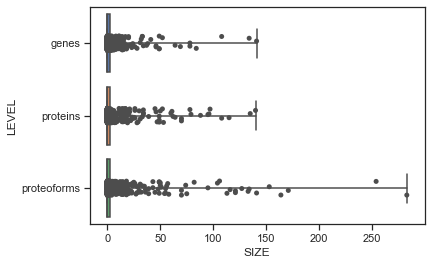

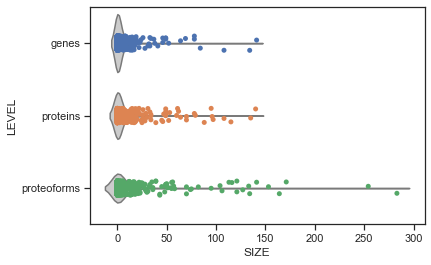

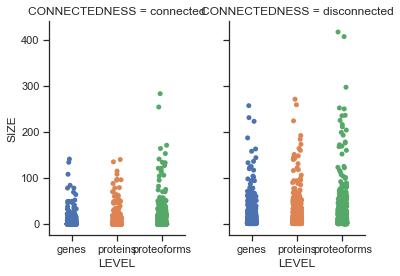

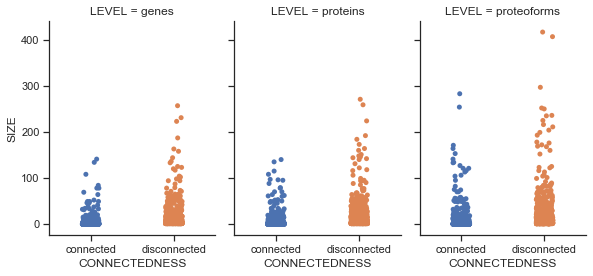

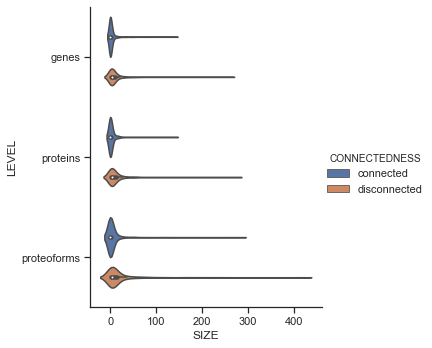

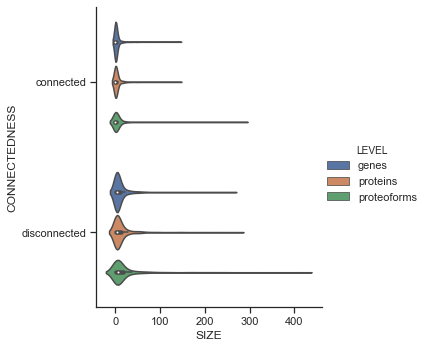

In [20]:
# Do the following plots for the modules in two cases: keeping disconnected nodes and removing them
    # Jitter plot showing the sizes for genes, proteins and proteoforms
    # Jitter plot showing the difference in size fom genes to proteins and from proteins to proteoforms.
# sizes_df = pd.DataFrame()
# for level in levels:
#     sizes_df[f"SIZES_{level.upper()}"] = sizes_dict[level]["SIZES"]

sns.set(style="ticks")
g = sns.FacetGrid(sizes_df, col="LEVEL", height=4, aspect=.5, hue="LEVEL", palette="Set2")
g.map(sns.barplot, "CONNECTEDNESS", "SIZE")
plt.show()

ax = sns.boxplot(x="SIZE", y="LEVEL", data=sizes_df_connected, whis=np.inf)
ax = sns.stripplot(x="SIZE", y="LEVEL", data=sizes_df_connected, jitter=True, color=".3")
plt.show()

ax = sns.violinplot(x="SIZE", y="LEVEL", data=sizes_df_connected, inner=None, color=".8")
ax = sns.stripplot(x="SIZE", y="LEVEL", data=sizes_df_connected, jitter=True)
plt.show()

g = sns.catplot(x="LEVEL", y="SIZE",
                hue="LEVEL", col="CONNECTEDNESS",
                data=sizes_df, kind="strip",
                jitter=True,
                height=4, aspect=.7);
plt.show()

g = sns.catplot(x="CONNECTEDNESS", y="SIZE",
                hue="CONNECTEDNESS", col="LEVEL",
                data=sizes_df, kind="strip",
                jitter=True,
                height=4, aspect=.7);
plt.show()

g = sns.catplot(x="SIZE", y="LEVEL", hue="CONNECTEDNESS", data=sizes_df, kind="violin")
plt.show()

g = sns.catplot(x="SIZE", y="CONNECTEDNESS", hue="LEVEL", data=sizes_df, kind="violin")
plt.show()

In [21]:
# Calculate and plot size variation
sizes_df = pd.concat(
    [pd.read_csv(f"reports/modules/module_sizes_{level}.tsv", sep="\t", names=["MODULES", f"SIZE_{level.upper()}"], header=0)[f"SIZE_{level.upper()}"] for level in LEVELS], 
    axis=1)

sizes_df[f"VARIATION_GENES_TO_PROTEINS"] = sizes_df["SIZE_PROTEINS"] - sizes_df["SIZE_GENES"]
sizes_df[f"VARIATION_PROTEINS_TO_PROTEOFORMS"] = sizes_df["SIZE_PROTEOFORMS"] - sizes_df["SIZE_PROTEINS"]

sizes_df['PERCENTAGE_GENES_TO_PROTEINS'] = sizes_df['VARIATION_GENES_TO_PROTEINS']*100/sizes_df['SIZE_GENES']
sizes_df['PERCENTAGE_PROTEINS_TO_PROTEOFORMS'] = sizes_df['VARIATION_PROTEINS_TO_PROTEOFORMS']*100/sizes_df['SIZE_PROTEINS']
sizes_df.fillna(0, inplace=True)
# sizes_df['PERCENTAGE_PROTEINS_TO_PROTEOFORMS'].unique()
sizes_df

,SIZE_GENES,SIZE_PROTEINS,SIZE_PROTEOFORMS,VARIATION_GENES_TO_PROTEINS,VARIATION_PROTEINS_TO_PROTEOFORMS,PERCENTAGE_GENES_TO_PROTEINS,PERCENTAGE_PROTEINS_TO_PROTEOFORMS
0,0,0,0,0,0,0.0,0.0
1,0,0,0,0,0,0.0,0.0
2,11,11,11,0,0,0.0,0.0
3,0,0,0,0,0,0.0,0.0
4,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...
787,0,0,0,0,0,0.0,0.0
788,0,0,0,0,0,0.0,0.0
789,0,0,0,0,0,0.0,0.0
790,0,0,0,0,0,0.0,0.0


In [22]:
size_variation = pd.concat({"GENES_TO_PROTEINS":sizes_df["VARIATION_GENES_TO_PROTEINS"], 
                            "PROTEINS_TO_PROTEOFORMS": sizes_df[f"VARIATION_PROTEINS_TO_PROTEOFORMS"]
                           }, names=["STEP", "INDEX"], axis=0)
size_variation = size_variation.to_frame()
size_variation["STEP"] = size_variation.index.get_level_values("STEP")
size_variation.columns = ["VARIATION", "STEP"]

size_variation

VARIATION                     STEP
STEP                    INDEX                                    
GENES_TO_PROTEINS       0              0        GENES_TO_PROTEINS
                        1              0        GENES_TO_PROTEINS
                        2              0        GENES_TO_PROTEINS
                        3              0        GENES_TO_PROTEINS
                        4              0        GENES_TO_PROTEINS
...                                  ...                      ...
PROTEINS_TO_PROTEOFORMS 787            0  PROTEINS_TO_PROTEOFORMS
                        788            0  PROTEINS_TO_PROTEOFORMS
                        789            0  PROTEINS_TO_PROTEOFORMS
                        790            0  PROTEINS_TO_PROTEOFORMS
                        791            0  PROTEINS_TO_PROTEOFORMS

[1584 rows x 2 columns]

c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1303: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1304: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1303: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
c:\git\pat

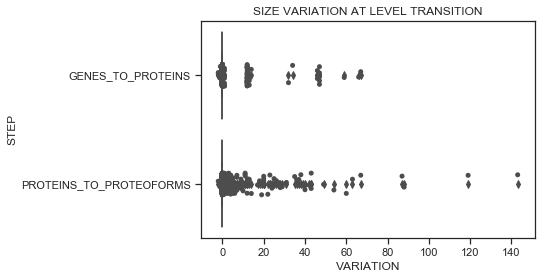

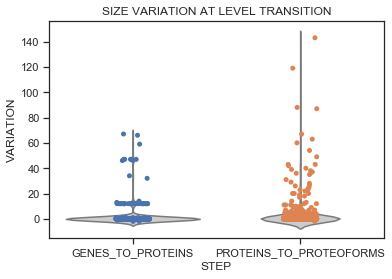

In [23]:
ax = sns.boxplot(x="VARIATION", y="STEP", data=size_variation, whis=np.inf)
ax = sns.stripplot(x="VARIATION", y="STEP", data=size_variation,
                   jitter=True, color=".3").set_title("SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

ax = sns.violinplot(x="STEP", y="VARIATION", data=size_variation, inner=None, color=".8")
ax = sns.stripplot(x="STEP", y="VARIATION", data=size_variation, jitter=True).set_title("SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

In [24]:
percentage_variation = pd.concat({"GENES_TO_PROTEINS":sizes_df["PERCENTAGE_GENES_TO_PROTEINS"], 
                            "PROTEINS_TO_PROTEOFORMS": sizes_df[f"PERCENTAGE_PROTEINS_TO_PROTEOFORMS"]
                           }, names=["STEP", "INDEX"], axis=0)
percentage_variation = percentage_variation.to_frame()
percentage_variation["STEP"] = percentage_variation.index.get_level_values("STEP")
percentage_variation.columns = ["PERCENTAGE", "STEP"]

percentage_variation

PERCENTAGE                     STEP
STEP                    INDEX                                     
GENES_TO_PROTEINS       0             0.0        GENES_TO_PROTEINS
                        1             0.0        GENES_TO_PROTEINS
                        2             0.0        GENES_TO_PROTEINS
                        3             0.0        GENES_TO_PROTEINS
                        4             0.0        GENES_TO_PROTEINS
...                                   ...                      ...
PROTEINS_TO_PROTEOFORMS 787           0.0  PROTEINS_TO_PROTEOFORMS
                        788           0.0  PROTEINS_TO_PROTEOFORMS
                        789           0.0  PROTEINS_TO_PROTEOFORMS
                        790           0.0  PROTEINS_TO_PROTEOFORMS
                        791           0.0  PROTEINS_TO_PROTEOFORMS

[1584 rows x 2 columns]

c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1303: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1304: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\matplotlib\cbook\__init__.py:1303: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
c:\git\pat

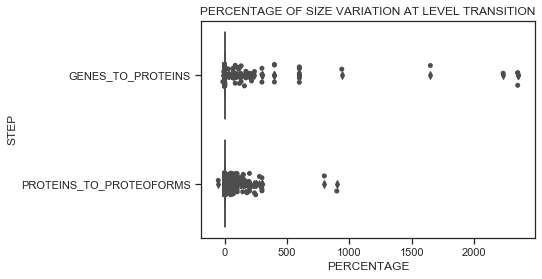

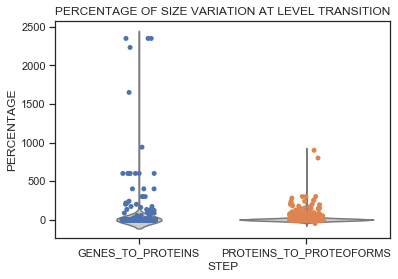

In [25]:
ax = sns.boxplot(x="PERCENTAGE", y="STEP", data=percentage_variation, whis=np.inf)
ax = sns.stripplot(x="PERCENTAGE", y="STEP", data=percentage_variation,
                   jitter=True, color=".3").set_title("PERCENTAGE OF SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

ax = sns.violinplot(x="STEP", y="PERCENTAGE", data=percentage_variation, inner=None, color=".8")
ax = sns.stripplot(x="STEP", y="PERCENTAGE", data=percentage_variation, jitter=True).set_title("PERCENTAGE OF SIZE VARIATION AT LEVEL TRANSITION")
plt.show()


In [26]:
scores = {level: pd.read_csv(f"reports/scores_{level}_overlap_similarity.tsv", sep='\t') for level in LEVELS}
assert len({len(scores[level]) for level in LEVELS}) == 1, "Error: the number of modules vary among levels."

FileNotFoundError: [Errno 2] File reports/scores_genes_overlap_similarity.tsv does not exist: 'reports/scores_genes_overlap_similarity.tsv'

In [27]:
import matplotlib.pyplot as plt

bins = 250
plt.figure(figsize=(13, 6), )
for level in LEVELS:
    sns.distplot(scores[level]['SCORE'] , hist = True, kde = True, kde_kws = {'linewidth': 1}, label=level, bins=bins)
plt.ylim(0, 20)
plt.legend(prop={'size': 16}, title = 'Overlap score density distribution')
plt.title('Overlap score distribution')
plt.xlabel('Overlap score')
plt.ylabel('Density')
plt.show()

NameError: name 'scores' is not defined

<Figure size 936x432 with 0 Axes>

In [28]:
df = pd.DataFrame(scores['genes'][['SCORE', 'OVERLAP_SIZE']])
df.columns = ['SCORE_GENES', 'OVERLAP_SIZE_GENES']
for level in ['proteins', 'proteoforms']:
    df['OVERLAP_SIZE_' + level.upper()] = scores[level]['OVERLAP_SIZE']
    df['SCORE_' + level.upper()] = scores[level]['SCORE']
df['SCORE_VARIATION'] = df['SCORE_PROTEOFORMS'] - df['SCORE_GENES'] 
df['SIZE_PERCENTAGE_VARIATION'] = scores['genes'].apply(lambda x: sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT1']] + sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT2']], axis=1)
df.index = scores['genes'].apply(lambda x: (x['TRAIT1'], x['TRAIT2']), axis=1)
df

NameError: name 'scores' is not defined

In [29]:
plt.figure(figsize=(13, 6))
plt.scatter(df['SCORE_VARIATION'], df['SIZE_PERCENTAGE_VARIATION'], alpha=0.5)
plt.title('Variation in size VS variation in overlap')
plt.xlabel('Size percentage variation')
plt.ylabel('Overlap variation')
plt.show()

NameError: name 'df' is not defined

<Figure size 936x432 with 0 Axes>

In [30]:
min_overlap_size = 10
max_overlap_size = 20

overlap_data = {level: pd.read_csv(f"reports/modules/pairs_overlap_data_{level}.tsv") for level in LEVELS}


ParserError: Error tokenizing data. C error: Expected 1 fields in line 55, saw 2


In [ ]:
# NODE_OVERLAP_SIZE_VARIATION_GENES_TO_PROTEINS
# NODE_OVERLAP_SIZE_VARIATION_PROTEINS_TO_PROTEOFORMS
# NODE_INTERFACE_SIZE_VARIATION_GENES_TO_PROTEINS
# NODE_INTERFACE_SIZE_VARIATION_PROTEINS_TO_PROTEOFORMS
# NODE_INTERFACE_SIZE_VARIATION_GENES_TO